In [86]:
import argparse
import logging
import time

import torch
import torchtext
from torch.utils.data import DataLoader
from torch.utils.data.dataset import random_split
from torchtext.data.functional import to_map_style_dataset
from torchtext.data.utils import get_tokenizer
from torchtext.datasets import DATASETS
from torchtext.prototype.transforms import load_sp_model, PRETRAINED_SP_MODEL, SentencePieceTokenizer
from torchtext.utils import download_from_url
from torchtext.vocab import build_vocab_from_iterator
import torch.nn as nn
from torch.nn.utils.rnn import pad_sequence
import torch.nn.functional as F
from torchtext.vocab import GloVe, FastText
from torch.optim import Adam
from tqdm import tqdm
from sklearn.metrics import accuracy_score
import gc
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import confusion_matrix
import scikitplot as skplt
import matplotlib.pyplot as plt
import numpy as np


## About Data Set

AG News (AG’s News Corpus) is a subdataset of AG's corpus of news articles constructed by assembling titles and description fields of articles from the 4 largest classes (“World”, “Sports”, “Business”, “Sci/Tech”) of AG’s Corpus. The AG News contains 30,000 training and 1,900 test samples per class.

## Tokenizer
- Different models tolenize in different ways. 
    - Word2Vec / GloVe does words (WordLevel).
    - BERT does WordPiece.
    - The original transformer did BytePairEncoding.
    - FastText uses n-grams.


In [87]:
TOKENIZER = get_tokenizer("basic_english")

## GloVe vectors

In [22]:
GLOVE = GloVe(name='840B', dim=300)
FASTTEXT = FastText()

.vector_cache/glove.840B.300d.zip: 2.18GB [06:51, 5.30MB/s]                               
100%|█████████▉| 2196016/2196017 [02:22<00:00, 15374.59it/s]
.vector_cache/wiki.en.vec: 6.60GB [03:01, 36.3MB/s]                                
100%|██████████| 2519370/2519370 [02:47<00:00, 15069.93it/s]


In [88]:
GLOVE.get_vecs_by_tokens(TOKENIZER("Hello, How are you?"), lower_case_backup=True).shape

torch.Size([6, 300])

In [89]:
GLOVE.get_vecs_by_tokens(TOKENIZER("<pad> <unk> the man Man ahsdhashdahsdhash"), lower_case_backup=True)

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.2720, -0.0620, -0.1884,  ...,  0.1302, -0.1832,  0.1323],
        [-0.1731,  0.2066,  0.0165,  ...,  0.1666, -0.3834, -0.0738],
        [-0.1731,  0.2066,  0.0165,  ...,  0.1666, -0.3834, -0.0738],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]])

# Forward-Forward Algo

## Dataset - get Positive Samples & Negative Samples

In [ ]:
max_words = 25
embed_len = 300

def vectorize_batch(batch):
    Y, X = list(zip(*batch))
    X = [TOKENIZER(x) for x in X]

    # X = [tokens+[""] * (max_words-len(tokens))  if len(tokens)<max_words else tokens[:max_words] for tokens in X]
    # X_tensor = torch.zeros(len(batch), max_words, embed_len)
    # for i, tokens in enumerate(X):
        # X_tensor[i] = GLOVE.get_vecs_by_tokens(tokens)
    # return X_tensor.reshape(len(batch), -1), torch.tensor(Y) - 1 ## Subtracted 1 from labels to bring in range [0,1,2,3] from [1,2,3,4]
    
    X_tensor = torch.zeros(len(batch), embed_len)
    for i, tokens in enumerate(X):
        X_tensor[i] = GLOVE.get_vecs_by_tokens(tokens).mean(dim=0) ## Averaging Embedding accross all words of text document
        # X_tensor[i, 0:4] = torch.zeros(4)
        # X_tensor[i, [Y[i]-1]] = 1
    return X_tensor, torch.tensor(Y) - 1 


target_classes = ["World", "Sports", "Business", "Sci/Tech"]

train_dataset, test_dataset  = torchtext.datasets.AG_NEWS()
train_dataset, test_dataset = to_map_style_dataset(train_dataset), to_map_style_dataset(test_dataset)

num_train = round(0.95*len(train_dataset))
split_train_, split_valid_ = random_split(train_dataset, [num_train, len(train_dataset) - num_train])

train_loader = DataLoader(split_train_, batch_size=1024, collate_fn=vectorize_batch)
valid_loader = DataLoader(split_valid_, batch_size=1024, collate_fn=vectorize_batch)
test_loader = DataLoader(test_dataset, batch_size=1024, collate_fn=vectorize_batch)

In [ ]:
for X, Y in train_loader:
    print(X)
    print(X.shape, Y.shape)
    break

## Model

In [ ]:
class EmbeddingClassifier(nn.Module):
    def __init__(self):
        super(EmbeddingClassifier, self).__init__()
        self.seq = nn.Sequential(
            nn.Linear(embed_len, 256),
            nn.ReLU(),

            nn.Linear(256,128),
            nn.ReLU(),

            nn.Linear(128,64),
            nn.ReLU(),

            nn.Linear(64, len(target_classes)),
        )

    def forward(self, X_batch):
        return self.seq(X_batch)

## Train the model

In [ ]:
def CalcValLossAndAccuracy(model, loss_fn, val_loader):
    with torch.no_grad():
        Y_shuffled, Y_preds, losses = [],[],[]
        for X, Y in val_loader:
            preds = model(X)
            loss = loss_fn(preds, Y)
            losses.append(loss.item())

            Y_shuffled.append(Y)
            Y_preds.append(preds.argmax(dim=-1))

        Y_shuffled = torch.cat(Y_shuffled)
        Y_preds = torch.cat(Y_preds)

        print("Valid Loss : {:.3f}".format(torch.tensor(losses).mean()))
        print("Valid Acc  : {:.3f}".format(accuracy_score(Y_shuffled.detach().numpy(), Y_preds.detach().numpy())))

In [ ]:
def TrainModel(model, loss_fn, optimizer, train_loader, val_loader, epochs=10):
    for i in range(1, epochs+1):
        losses = []
        for X, Y in tqdm(train_loader):
            # X: Batch_size x (25*300)
            # Y: Batch_size x 1
            # Y_preds: Batch_size x num_class
            Y_preds = model(X) 

            loss = loss_fn(Y_preds, Y)
            losses.append(loss.item())

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        if i%5==0:
            print("Train Loss : {:.3f}".format(torch.tensor(losses).mean()))
            CalcValLossAndAccuracy(model, loss_fn, val_loader)

In [ ]:
epochs = 25
learning_rate = 1e-3

loss_fn = nn.CrossEntropyLoss()
embed_classifier = EmbeddingClassifier()
optimizer = Adam(embed_classifier.parameters(), lr=learning_rate)

TrainModel(embed_classifier, loss_fn, optimizer, train_loader, valid_loader, epochs)

## Prediction

In [ ]:
def MakePredictions(model, loader):
    Y_shuffled, Y_preds = [], []
    for X, Y in loader:
        preds = model(X)
        Y_preds.append(preds)
        Y_shuffled.append(Y)
    gc.collect()
    Y_preds, Y_shuffled = torch.cat(Y_preds), torch.cat(Y_shuffled)

    return Y_shuffled.detach().numpy(), F.softmax(Y_preds, dim=-1).argmax(dim=-1).detach().numpy()

Y_actual, Y_preds = MakePredictions(embed_classifier, test_loader)

In [ ]:
print("Test Accuracy : {}".format(accuracy_score(Y_actual, Y_preds)))
print("\nClassification Report : ")
print(classification_report(Y_actual, Y_preds, target_names=target_classes))
print("\nConfusion Matrix : ")
print(confusion_matrix(Y_actual, Y_preds))

In [ ]:
skplt.metrics.plot_confusion_matrix([target_classes[i] for i in Y_actual], [target_classes[i] for i in Y_preds],
                                    normalize=True,
                                    title="Confusion Matrix",
                                    cmap="Purples",
                                    hide_zeros=True,
                                    figsize=(5,5)
                                    );
plt.xticks(rotation=90);

# Baseline

## Dataset

In [90]:
max_words = 25
embed_len = 300

def vectorize_batch(batch):
    Y, X = list(zip(*batch))
    X = [TOKENIZER(x) for x in X]

    # X = [tokens+[""] * (max_words-len(tokens))  if len(tokens)<max_words else tokens[:max_words] for tokens in X]
    # X_tensor = torch.zeros(len(batch), max_words, embed_len)
    # for i, tokens in enumerate(X):
        # X_tensor[i] = GLOVE.get_vecs_by_tokens(tokens)
    # return X_tensor.reshape(len(batch), -1), torch.tensor(Y) - 1 ## Subtracted 1 from labels to bring in range [0,1,2,3] from [1,2,3,4]
    
    X_tensor = torch.zeros(len(batch), embed_len)
    for i, tokens in enumerate(X):
        X_tensor[i] = GLOVE.get_vecs_by_tokens(tokens).mean(dim=0) ## Averaging Embedding accross all words of text document
        # X_tensor[i, 0:4] = torch.zeros(4)
        # X_tensor[i, [Y[i]-1]] = 1
    return X_tensor, torch.tensor(Y) - 1 


target_classes = ["World", "Sports", "Business", "Sci/Tech"]

train_dataset, test_dataset  = torchtext.datasets.AG_NEWS()
train_dataset, test_dataset = to_map_style_dataset(train_dataset), to_map_style_dataset(test_dataset)

num_train = round(0.95*len(train_dataset))
split_train_, split_valid_ = random_split(train_dataset, [num_train, len(train_dataset) - num_train])

train_loader = DataLoader(split_train_, batch_size=1024, collate_fn=vectorize_batch)
valid_loader = DataLoader(split_valid_, batch_size=1024, collate_fn=vectorize_batch)
test_loader = DataLoader(test_dataset, batch_size=1024, collate_fn=vectorize_batch)

In [91]:
for X, Y in train_loader:
    print(X)
    print(X.shape, Y.shape)
    break

tensor([[-0.0289,  0.1634,  0.0320,  ..., -0.0973,  0.0065,  0.0266],
        [ 0.0401,  0.1178,  0.0588,  ..., -0.0038, -0.0684,  0.0516],
        [ 0.1497,  0.0450, -0.0933,  ..., -0.1014, -0.0440, -0.1521],
        ...,
        [-0.0941,  0.0740,  0.0408,  ...,  0.1033, -0.0083,  0.0343],
        [-0.2283,  0.2360,  0.0633,  ..., -0.0673, -0.0554,  0.1201],
        [-0.1545,  0.1495,  0.0220,  ..., -0.0702, -0.0423,  0.1718]])
torch.Size([1024, 300]) torch.Size([1024])


## Model

In [92]:
class EmbeddingClassifier(nn.Module):
    def __init__(self):
        super(EmbeddingClassifier, self).__init__()
        self.seq = nn.Sequential(
            nn.Linear(embed_len, 256),
            nn.ReLU(),

            nn.Linear(256,128),
            nn.ReLU(),

            nn.Linear(128,64),
            nn.ReLU(),

            nn.Linear(64, len(target_classes)),
        )

    def forward(self, X_batch):
        return self.seq(X_batch)

## Train the model

In [93]:
def CalcValLossAndAccuracy(model, loss_fn, val_loader):
    with torch.no_grad():
        Y_shuffled, Y_preds, losses = [],[],[]
        for X, Y in val_loader:
            preds = model(X)
            loss = loss_fn(preds, Y)
            losses.append(loss.item())

            Y_shuffled.append(Y)
            Y_preds.append(preds.argmax(dim=-1))

        Y_shuffled = torch.cat(Y_shuffled)
        Y_preds = torch.cat(Y_preds)

        print("Valid Loss : {:.3f}".format(torch.tensor(losses).mean()))
        print("Valid Acc  : {:.3f}".format(accuracy_score(Y_shuffled.detach().numpy(), Y_preds.detach().numpy())))

In [94]:
def TrainModel(model, loss_fn, optimizer, train_loader, val_loader, epochs=10):
    for i in range(1, epochs+1):
        losses = []
        for X, Y in tqdm(train_loader):
            # X: Batch_size x (25*300)
            # Y: Batch_size x 1
            # Y_preds: Batch_size x num_class
            Y_preds = model(X) 

            loss = loss_fn(Y_preds, Y)
            losses.append(loss.item())

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        if i%5==0:
            print("Train Loss : {:.3f}".format(torch.tensor(losses).mean()))
            CalcValLossAndAccuracy(model, loss_fn, val_loader)

In [95]:
epochs = 25
learning_rate = 1e-3

loss_fn = nn.CrossEntropyLoss()
embed_classifier = EmbeddingClassifier()
optimizer = Adam(embed_classifier.parameters(), lr=learning_rate)

TrainModel(embed_classifier, loss_fn, optimizer, train_loader, valid_loader, epochs)

100%|██████████| 112/112 [00:14<00:00,  7.54it/s]


Train Loss : 0.261
Valid Loss : 0.261
Valid Acc  : 0.907


100%|██████████| 112/112 [00:15<00:00,  7.29it/s]


Train Loss : 0.224
Valid Loss : 0.244
Valid Acc  : 0.917


100%|██████████| 112/112 [00:15<00:00,  7.34it/s]


Train Loss : 0.197
Valid Loss : 0.243
Valid Acc  : 0.919


100%|██████████| 112/112 [00:15<00:00,  7.40it/s]


Train Loss : 0.172
Valid Loss : 0.249
Valid Acc  : 0.918


100%|██████████| 112/112 [00:15<00:00,  7.45it/s]


Train Loss : 0.146
Valid Loss : 0.270
Valid Acc  : 0.914


## Prediction

In [96]:
def MakePredictions(model, loader):
    Y_shuffled, Y_preds = [], []
    for X, Y in loader:
        preds = model(X)
        Y_preds.append(preds)
        Y_shuffled.append(Y)
    gc.collect()
    Y_preds, Y_shuffled = torch.cat(Y_preds), torch.cat(Y_shuffled)

    return Y_shuffled.detach().numpy(), F.softmax(Y_preds, dim=-1).argmax(dim=-1).detach().numpy()

Y_actual, Y_preds = MakePredictions(embed_classifier, test_loader)

In [97]:
print("Test Accuracy : {}".format(accuracy_score(Y_actual, Y_preds)))
print("\nClassification Report : ")
print(classification_report(Y_actual, Y_preds, target_names=target_classes))
print("\nConfusion Matrix : ")
print(confusion_matrix(Y_actual, Y_preds))

Test Accuracy : 0.9180263157894737

Classification Report : 
              precision    recall  f1-score   support

       World       0.93      0.91      0.92      1900
      Sports       0.98      0.97      0.97      1900
    Business       0.86      0.90      0.88      1900
    Sci/Tech       0.91      0.89      0.90      1900

    accuracy                           0.92      7600
   macro avg       0.92      0.92      0.92      7600
weighted avg       0.92      0.92      0.92      7600


Confusion Matrix : 
[[1736   29   92   43]
 [  31 1837   24    8]
 [  54    8 1717  121]
 [  46   10  157 1687]]


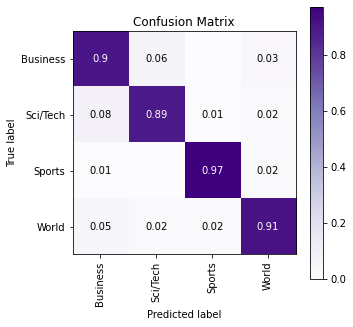

In [98]:
skplt.metrics.plot_confusion_matrix([target_classes[i] for i in Y_actual], [target_classes[i] for i in Y_preds],
                                    normalize=True,
                                    title="Confusion Matrix",
                                    cmap="Purples",
                                    hide_zeros=True,
                                    figsize=(5,5)
                                    );
plt.xticks(rotation=90);